In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, ieti_cy
from pyiga import assemble
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools
from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)
import numba as nb    
#from numba import njit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiDP:
    def __init__(self, MP, dir_data, neu_data=None, elim=True):
        self.space = MP
        self.elim = elim
        
        self.dir_idx=dict()
        self.dir_vals=dict()
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        for key in dir_data:
            for p,b in self.space.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(self.dir_idx[p], return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
        
        if self.elim:
            p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
            self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        else:
            self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
            self.B = self.space.Constr
            
            
        self.N = [Ba.shape[1] for Ba in self.Basisk]
        self.N_ofs = np.cumsum([0]+self.N)
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]
        self.Basis=scipy.sparse.block_diag(self.Basisk).tocsr()
        self.P2Gk =[]
        
        for p in range(self.space.numpatches):
            X = self.Basisk[p].tocoo()
            idx = np.where(np.isclose(X.data,1))
            X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
            D = (X.T@self.Basisk[p]).sum(axis=1).A.ravel()
            #assert all(abs(D)>1e-12), 'D has zeros.'
            #S = scipy.sparse.spdiags(1/D,[0],len(D),len(D))
            self.P2Gk.append(X.T)
            I = np.zeros(self.Basisk[p].shape[0])
            if p in self.dir_idx:
                I[self.dir_idx[p]] = 1
                self.dir_idx[p] = np.where(np.isclose(self.P2Gk[p]@I,1))[0]
        
        self.P2G = scipy.sparse.block_diag(self.P2Gk)
        if len(self.dir_idx)>0:
            self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        else:
            self.global_dir_idx = np.array([])
        self.free_dofs = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx)
        self.free_dofs_pp = [np.arange(self.N[p]) if p not in self.dir_idx else np.setdiff1d(np.arange(self.N[p]),self.dir_idx[p]) for p in range(self.space.numpatches)]
        
        #self.B = self.B @ scipy.sparse.block_diag(self.Basisk)
        
        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.global_dir_idx)
        
        self.Rbb = []
        self.Rii = []
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask = np.zeros(self.N[p], dtype=bool)
            nnz_per_col = self.Bk[p].getnnz(axis=0)
            if p in self.dir_idx:
                intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.dir_idx[p])
            else:
                intfs = np.where(nnz_per_col > 0)[0]
            mask[intfs]=True
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rbb.append(Id[mask].tocsc())
            mask = np.ones(self.N[p], dtype=bool)
            mask[intfs]=False
            if p in self.dir_idx:
                mask[self.dir_idx[p]]=False
            self.Rii.append(Id[mask].tocsc())
            
        
    def assemble(self, problem, f):
        Ak = [Ba.T @ assemble.assemble(problem, kvs, bfuns=[('u',1), ('v',1)], geo=geo)@Ba for Ba, ((kvs, geo),_) in zip(self.Basisk, self.space.mesh.patches)]
        A = scipy.sparse.block_diag(Ak, format='csr')
        rhsk = [Ba.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f).ravel() for Ba, ((kvs, geo),_) in zip(self.Basisk,self.space.mesh.patches)]

        # self.Abb = self.Rbb.dot(A).dot(self.Rbb.T)
        # self.Aii = self.Rii.dot(A).dot(self.Rii.T)
        # self.Abi = self.Rbb.dot(A).dot(self.Rii.T)
        # self.Aib = self.Abi.T
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(Ak[p], rhsk[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        self.rhsk = [rhsk[p] if p not in self.dir_idx else self.BCRestr[p].b for p in range(self.space.numpatches)]
        self.Ak = [Ak[p] if p not in self.dir_idx else self.BCRestr[p].A for p in range(self.space.numpatches)]
        self.A = scipy.sparse.block_diag(self.Ak)
        # self.A = BCRestr.A
        # self.rhs = BCRestr.b
        
    def generate_prim(self, elim, fat):
        Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if elim:
            if fat:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in Nodes:
                    if isinstance(key,int32):
                        dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in Nodes:
                if isinstance(key,int32):
                    dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:
                    constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
                    dofs_coarse = Nodes[key][1]
                    dofs=np.concatenate([Nodes[key][0],Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        
    # def construct_primal_constraints_elim(self, redundant=False):
    #     self.Ck = []
    #     self.Rk = []
    #     kvs = self.space.mesh.kvs
    #     geos = self.space.mesh.geos
    #     Nodes = self.space.get_nodes()
    #     self.eliminate_constraints = np.array([], dtype=int)
    #     Prim = {}
    #     i=0
        
    #     for key in Nodes:
    #         if isinstance(key,int32):
    #             dofs = self.Basis.tocsr()[Nodes[key][0],:].indices
    #             Prim[i] = (dofs,np.ones(len(dofs)))
    #             i+=1
    #         else:
    #             constr = (self.space.Constr.tocsc()[:,Nodes[key][0][0]]==1).indices
    #             coeffs = abs(self.space.Constr[constr,:][:,Nodes[key][1]].data)
    #             dofs_coarse = self.Basis.tocsr()[Nodes[key][1],:].indices
    #             dofs=[]
    #             for dof in dofs_coarse:
    #                 found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
    #                 dofs.append(found_dofs)
    #             Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
    #             i+=1

    #     loc_c_prim = np.concatenate([Prim[key][0] for key in Prim])
    #     coeffs = np.concatenate([Prim[key][1] for key in Prim])
    #     loc_c_prim_idx = np.repeat(np.arange(len(Prim)),[len(Prim[i][0]) for i in Prim])
    #     p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
    #     Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

    #     for p in range(MP.numpatches):
    #         c_primal_free = Prim_pp[p][0] - self.N_ofs[p]
    #         data = Prim_pp[p][1]
    #         idx = np.bincount(Prim_pp[p][2])
    #         idx = idx[idx>0]
    #         rows = np.repeat(np.arange(len(idx)),idx)
    #         cols = c_primal_free
    #         ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
    #         ck = ck[:,self.free_dofs_pp[p]]
    #         self.Ck.append(ck.tocsr())
    #         m, n = ck.shape[0], len(Prim)
    #         jj = np.unique(Prim_pp[p][2])
    #         self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
    #         if not redundant:
    #             nnz_per_row = self.B[:,self.Prim_pp[p][0]].getnnz(axis=1)
    #             result = np.where(nnz_per_row > 0)[0]
    #             self.eliminate_constraints = np.union1d(result, self.eliminate_constraints)
        
    #     keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
    #     self.B = self.B[keep_constr,:]
    #     self.Bk = [B[keep_constr,:] for B in self.Bk]
    #     self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_constraints(self, redundant=False, fat=True):
        self.Ck = []
        self.Rk = []
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos
        self.eliminate_constraints = np.array([], dtype=int)
        Nodes=self.space.get_nodes()
        
        self.generate_prim(elim=self.elim, fat=fat)
        
        loc_c_prim = np.concatenate([self.Prim[key][0] for key in self.Prim])
        coeffs = np.concatenate([self.Prim[key][1] for key in self.Prim])
        loc_c_prim_idx = np.repeat(np.arange(len(self.Prim)),[len(self.Prim[i][0]) for i in self.Prim])
        p_idx = [(loc_c_prim >= self.N_ofs[p]) & (loc_c_prim < self.N_ofs[p+1]) for p in range(self.space.numpatches)]
        self.Prim_pp = {p : (loc_c_prim[p_idx[p]],coeffs[p_idx[p]],loc_c_prim_idx[p_idx[p]]) for p in range(self.space.numpatches)}

        for p in range(MP.numpatches):
            c_primal_free = self.Prim_pp[p][0] - self.N_ofs[p]
            data = self.Prim_pp[p][1]
            idx = np.bincount(self.Prim_pp[p][2])
            idx = idx[idx>0]
            rows = np.repeat(np.arange(len(idx)),idx)
            cols = c_primal_free
            ck = coo_matrix((data, (rows, cols)),(len(idx),self.N[p])).tocsc()
            ck = ck[:,self.free_dofs_pp[p]]
            self.Ck.append(ck.tocsr())
            m, n = ck.shape[0], len(self.Prim)
            jj = np.unique(self.Prim_pp[p][2])
            self.Rk.append(scipy.sparse.coo_matrix((np.ones(m),(np.arange(m),jj)),(m,n)))
            
        if not redundant:
            if self.elim:
                if fat:
                    nnz_per_row = self.B[:,np.concatenate([self.Prim_pp[p][0] for p in range(self.space.numpatches)])].getnnz(axis=1)
                    self.eliminate_constraints = np.where(nnz_per_row > 0)[0]
                else:
                    dofs = [Nodes[key][0] for key in Nodes if isinstance(key,int32)]
                    if len(dofs)>0:
                        dofs = np.concatenate([Nodes[key][0] for key in Nodes if isinstance(key,int32)])
                    dofs_new = (self.Basis[dofs,:]==1).indices
                    self.eliminate_constraints = np.where(self.B[:,dofs_new].getnnz(axis=1))
            else:
                self.eliminate_constraints = (MP.Constr.tocsc()[:,np.concatenate([Nodes[key][0] for key in Nodes])]==1).indices
                    
        
        keep_constr = np.setdiff1d(np.arange(self.B.shape[0]),self.eliminate_constraints)
        self.B = self.B[keep_constr,:]
        self.Bk = [B[keep_constr,:] for B in self.Bk]
        self.C = scipy.sparse.block_diag(self.Ck)
        
    def construct_primal_basis(self):
        self.PsiK=[]
        self.Deltak=[]
        self.loc_solver = []
        self.A_prim = np.zeros(2*(len(self.Prim),))
        for p in range(len(self.space.mesh.patches)):
            a = self.Ak[p]
            c = self.Ck[p]
            RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
            self.loc_solver.append(solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True))
            psi = self.loc_solver[p].dot(RHS)
            psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
            if psi.ndim==1: psi=psi[:,None]
            if delta.ndim==1: delta=delta[:,None]
            self.PsiK.append(psi@self.Rk[p])
            self.Deltak.append(delta)
            self.A_prim -= self.Rk[p].T@delta@self.Rk[p]

        self.Psi=np.vstack(self.PsiK)
        
    def remove_dir_from_jumps(self):
        self.B = self.B[:,self.free_dofs]
        keep = np.where(self.B.getnnz(axis=1)>0)[0]
        self.B=self.B[keep,:]
        idx_p = [(self.free_dofs < self.N_ofs[p+1]) & (self.free_dofs >= self.N_ofs[p]) for p in range(self.space.numpatches)]
        self.Bk = [self.B[:,idx_p[p]] for p in range(self.space.numpatches)]
        
    def compute_F(self):
        #Bk = [b[np.where(b.getnnz(axis=1)>0)[0]] for b in Bk]
        self.Bk_ = [aslinearoperator(scipy.sparse.bmat([[b,np.zeros((b.shape[0],self.Ck[p].shape[0]))]], format='csr')) for p,b in enumerate(self.Bk)] 
        #PTAP = self.A_prim#self.Psi.T@self.A@self.Psi
        #PTBT = self.Psi.T@self.B.T
        BP   = self.B@self.Psi
        
        rhs = np.concatenate(self.rhsk)
        self.rhsk_ = [np.concatenate([f,np.zeros(self.Ck[p].shape[0])]) for p,f in enumerate(self.rhsk)]
        
        #self.loc_solver = [solvers.make_solver(scipy.sparse.bmat([[a,    c.T], [c,    None]], format='csr'), spd=False, symmetric=True) for a,c in zip(self.Ak, self.Ck)]
        self.solver_prim = solvers.make_solver(self.A_prim, spd=True, symmetric=True)
        F1 = aslinearoperator(BP@self.solver_prim.dot(BP.T)) 
        F2 = sum([b@Ak_inv.dot(b.T) for b, Ak_inv in zip(self.Bk_, self.loc_solver)])

        b1 = BP@self.solver_prim.dot(self.Psi.T@rhs)
        b2 = np.sum([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, self.rhsk_)],axis=0)

        #print(self.solver_prim.dot(self.Psi.T@rhs))
        #print([b.dot(Ak_inv.dot(f)) for b, Ak_inv,f in zip(self.Bk_, self.loc_solver, rhsk_)])
        
        return F1+F2, b1+b2
    
    def MsD(self, method="diagonal"):
        B = self.B
        Bk = self.Bk
        Rb = [self.Rbb[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        Ri = [self.Rii[p][:,self.free_dofs_pp[p]] for p in range(self.space.numpatches)]
        self.B_gamma = scipy.sparse.hstack([Bk[p]@Rb[p].T for p in range(self.space.numpatches)])

        self.Abb = [aslinearoperator(Rb[p]@self.Ak[p]@Rb[p].T) for p in range(self.space.numpatches)]
        self.Aii = [Ri[p]@self.Ak[p]@Ri[p].T for p in range(self.space.numpatches)]
        self.Abi = [aslinearoperator(Rb[p]@self.Ak[p]@Ri[p].T) for p in range(self.space.numpatches)]
        
        self.S = [Abb - Abi@solvers.make_solver(Aii, spd=True).dot(Abi.T) for Abb,Abi,Aii in zip(self.Abb,self.Abi,self.Aii)]
        ofs = np.cumsum([0]+[s.shape[0] for s in self.S])
        
        if method=="pseudo":   ###TODO: Do not compute matrix exactly but use least squares as an operator
            t=time.time()
            P = np.linalg.pinv(self.B_gamma.A)
            P[abs(P)<1e-12]=0
            self.BgD=scipy.sparse.csr_matrix(P).T
            print("Computing pseudoinverse took "+str(time.time()-t)+" seconds.")
        elif method=="diagonal":
            D = self.B_gamma.getnnz(axis=0)
            D = 1/(1+D)
            self.D = scipy.sparse.diags(D, format='csr')
            self.BgD = self.B_gamma@self.D
        elif method=="pick":
            self.R = 1*(self.B_gamma==1).T
            self.BgD = self.B_gamma@self.R@self.R.T
        print("Convergence condition: "+str(scipy.sparse.linalg.norm(self.B_gamma@self.BgD.T@self.B_gamma-self.B_gamma)<1e-8))
        # for p in range(self.space.numpatches):
        #     print(self.BgD[:,ofs[p]:ofs[p+1]].shape, self.S[p].shape, self.BgD[:,ofs[p]:ofs[p+1]].T.shape)
        return sum([aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]])@self.S[p].dot(aslinearoperator(self.BgD[:,ofs[p]:ofs[p+1]].T)) for p in range(self.space.numpatches)])

    def construct_solution(self, lam):
        u=[]
        u_prim = self.solver_prim.dot(self.Psi.T@(np.concatenate(self.rhsk)-self.B.T@lam))
        for p in range(self.space.numpatches):
            sol = self.loc_solver[p].dot(np.r_[self.rhsk[p]-self.Bk[p].T@lam,np.zeros(self.Ck[p].shape[0])])[:self.Ck[p].shape[1]]
            #print(sol.shape)
            sol += self.PsiK[p]@u_prim
            if p in self.BCRestr:
                sol = self.BCRestr[p].complete(sol)
            u.append(self.Basisk[p]@sol)
        return u
        

In [3]:
def checkerboard1(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(9) if i%2==1})
    return M

In [4]:
def checkerboard2(deg,N,k):
    geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    ]

    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
    #kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
    kvs=4*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

    # set up a PatchMesh object, which detects interfaces between patches
    M = topology.PatchMesh(patches)
    for j in range(k):
        M.h_refine(patches = {i : -1 for i in range(4) if i==1 or i==2})
    return M

In [5]:
def Lshape(deg,N,depth=3):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.unit_square())]
    M = topology.PatchMesh(patches)

    for i in range(depth):
        M.h_refine({0:None})
    return M

In [6]:
def example_geo(deg, N):
    patches = [(2*(bspline.make_knots(deg,0.0,1.0,N),),geometry.quarter_annulus())]
    M = topology.PatchMesh(patches)

    M.h_refine({0:0});
    M.h_refine({0:1});
    #M.h_refine({1:1});
    #M.h_refine({0:-1,3:-1});
    #M.h_refine({2:0});
    #M.h_refine({1:1});
    return M

setting up constraints took 0.06104326248168945 seconds.
Basis setup took 0.013234376907348633 seconds
Convergence condition: True
pcg with preconditioned condition number κ ~ 1.3560932804005301 stopped after 4 iterations with relres 6.713108097757477e-11
1.0002320242906324 1.3564079269819465


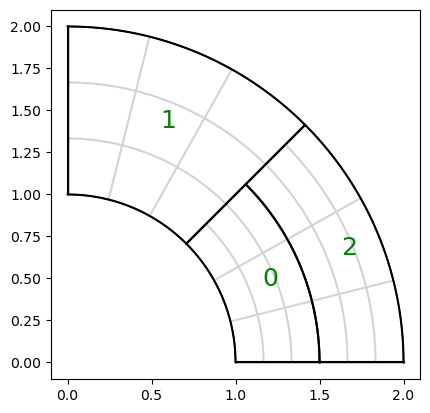

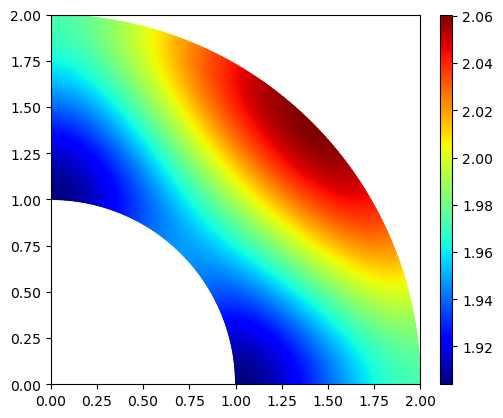

In [7]:
f = lambda x, y: x+y
g = lambda x, y: 0.

params = {'f' : f, 'g' : g}
deg = 8
N = 3
elim=1
fat=1

#M = checkerboard2(deg,N,1)
M = example_geo(deg,N)
#M = Lshape(deg,N,4)
#M = topology.PatchMesh(list(zip(5*(2*(bspline.make_knots(deg,0,1,N),),),geometry.mp_disk())))
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0:g}
#MP.set_dirichlet_boundary(dir_data)
MP.mesh.draw(patch_idx=1,nodes=0,knots=1)
I = IetiDP(MP, dir_data = {}, elim=elim)
I.assemble(problem='(inner(grad(u),grad(v))+u*v)* dx',f=lambda x,y: x+y)
I.construct_primal_constraints(redundant=False, fat = fat)
I.construct_primal_basis()
I.remove_dir_from_jumps()
F,b = I.compute_F()
#print(np.max(I.Psi))
#print(norm(b))
MsD = I.MsD(method = "diagonal")
x0 = None
#x0 = np.random.rand(len(b))
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=x0, maxiter=200, P=MsD, output=1, rtol=1e-8, atol=1e-12)
#lam, info = scipy.sparse.linalg.cg(F, b, x0=x0, maxiter=2000, M = MsD, rtol=1e-5, atol=1e-12)
#print(info)
print(min_eig, max_eig)
#u_loc0 = I.construct_solution(lam0)
u_loc = I.construct_solution(lam)
MP.plot(np.concatenate(u_loc))

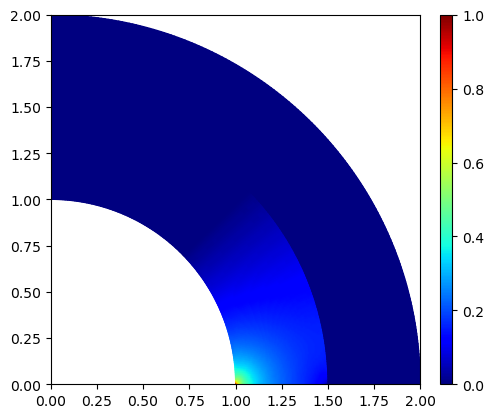

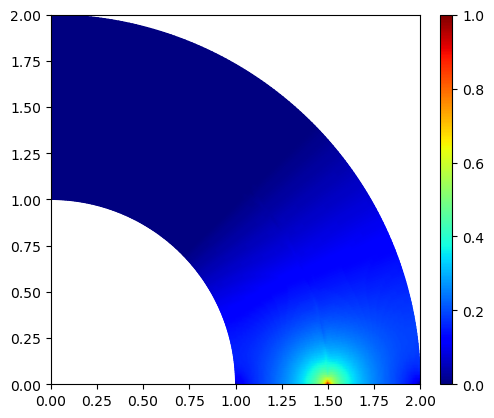

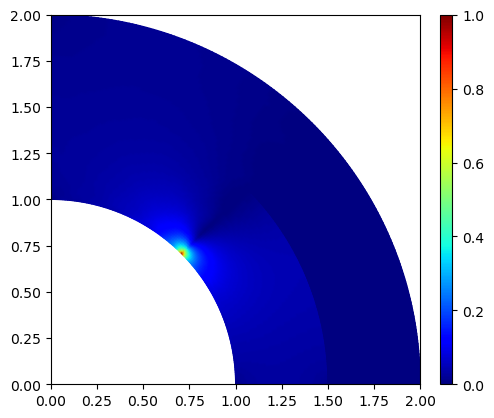

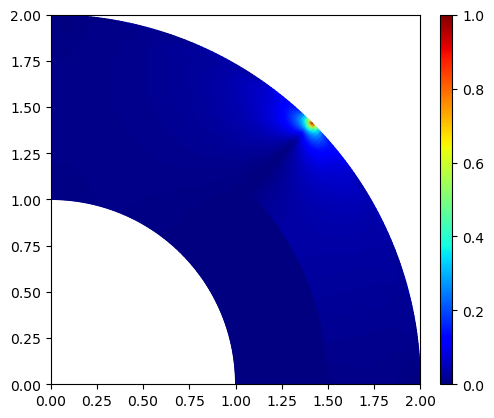

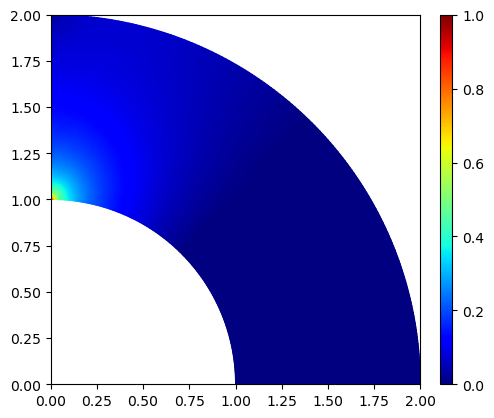

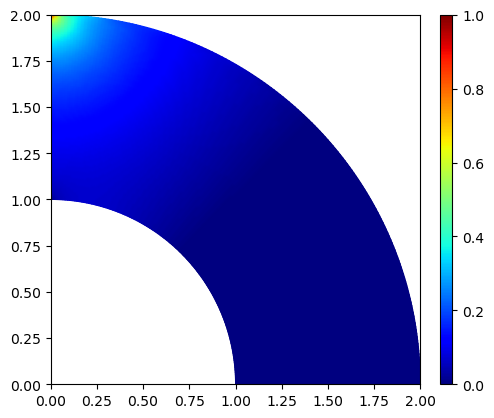

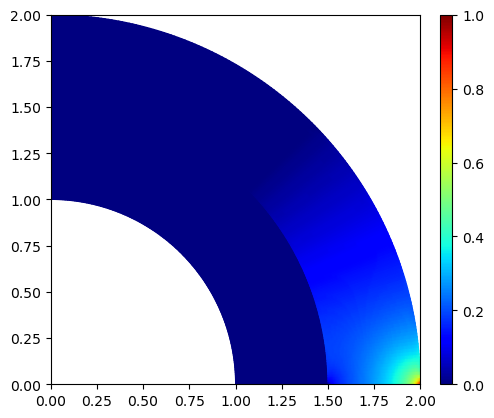

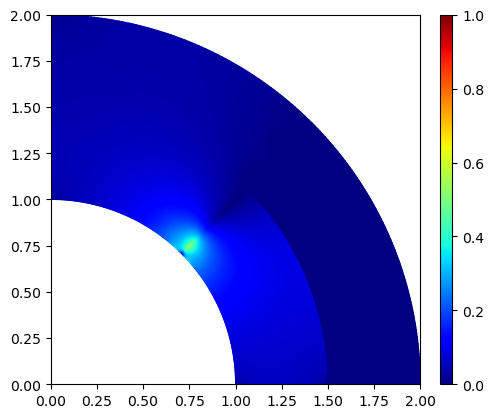

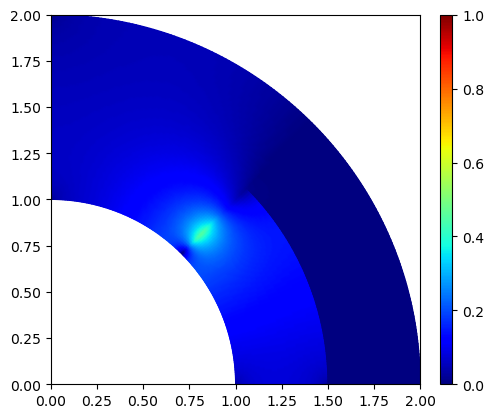

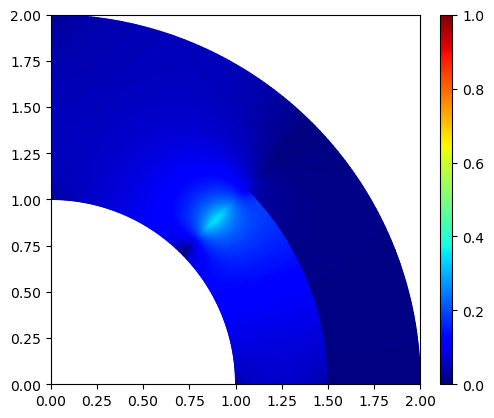

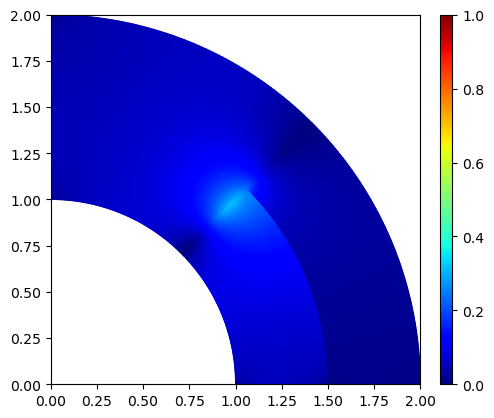

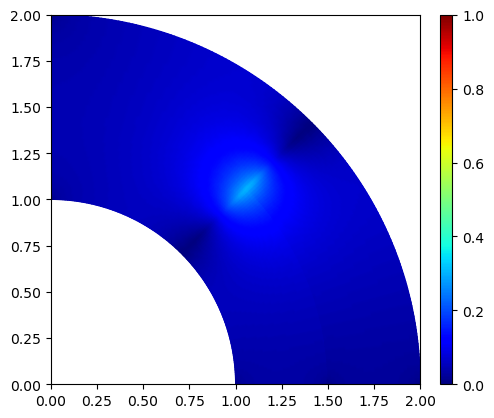

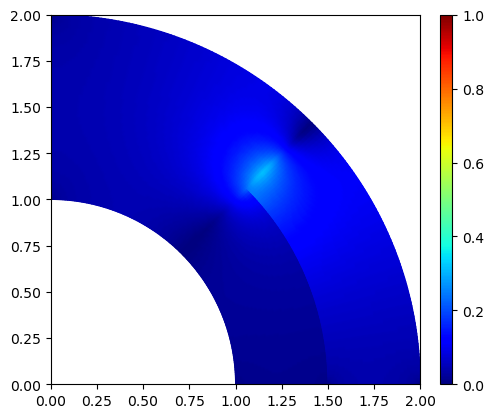

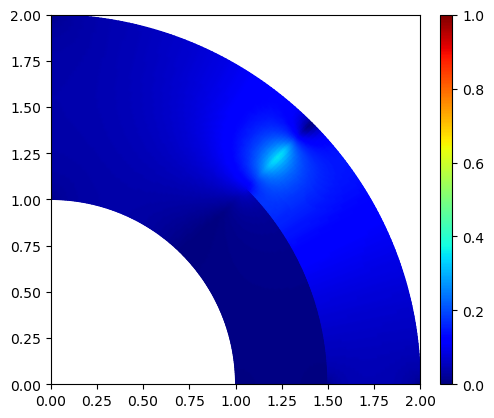

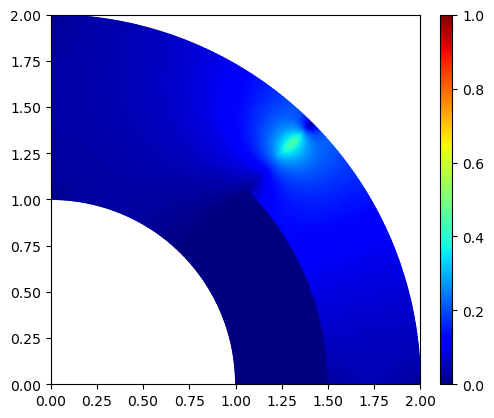

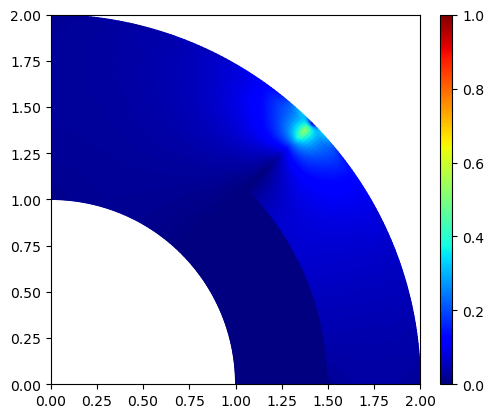

In [202]:
for i in range(I.Psi.shape[1]):
    MP.plot(I.Basis[:,I.free_dofs]@I.Psi[:,i],range=(0,1))

In [203]:
loc_inv = [sol.dot(np.identity(sol.shape[0])) for sol in I.loc_solver]

In [204]:
norm(loc_inv[0])

8986556.916358756

In [205]:
M = scipy.sparse.bmat([[I.Ak[0],I.Ck[0].T],[I.Ck[0],None]])

In [209]:
norm(np.linalg.inv(M.A))

8986556.916692786

In [207]:
np.linalg.cond(I.Ak[0].A)

2635018987352.0938

In [208]:
np.linalg.cond(M.A)

45306342.8838821

In [187]:
I.Ck[0].shape

(12, 120)

In [188]:
I.Bk_

[<9x132 MatrixLinearOperator with dtype=float64>,
 <9x134 MatrixLinearOperator with dtype=float64>,
 <9x132 MatrixLinearOperator with dtype=float64>]

In [146]:
I.rhsk_[1].shape

(329,)

In [85]:
I.Basis[:,I.free_dofs]

<972x962 sparse matrix of type '<class 'numpy.float64'>'
	with 1108 stored elements in Compressed Sparse Row format>

In [86]:
norm(I.Basis[:,I.free_dofs]@I.Psi)

14.672197170642427

In [87]:
norm(I.Basis[:,I.free_dofs].A)

30.843786697280013

In [88]:
norm(I.Psi)

44216.86592999137

In [90]:
norm(I.Bk[0]@I.PsiK[0])

42933.96968321964

In [227]:
loc_solver_mat = [loc.dot(np.identity(loc.shape[0])) for loc in I.loc_solver]

In [228]:
prim_solver_mat = I.solver_prim.dot(np.identity(I.solver_prim.shape[0]))

8.687686519516014

In [56]:
Fmat = F.dot(np.identity(len(b)))

In [66]:
lam0,flag,_,_,_,_,_,_,_,_ = scipy.sparse.linalg.lsqr(Fmat,b)
print(flag)
u_loc0 = I.construct_solution(lam0)

1


In [67]:
norm(F@lam0-b)

3.638712304138661e-06

In [68]:
norm(F@lam-b)

6.60674078187244e-10

In [69]:
t=time.time()
Kh = MP.assemble_volume('(inner(grad(u),grad(v))+u*v)* dx',arity=2)
fh = MP.assemble_volume('f * v * dx', arity=1, f=f)
#bcs = MP.compute_dirichlet_bcs({0:g})
#LS = assemble.RestrictedLinearSystem(Kh,fh,bcs)
print(time.time()-t)
u_sol = solvers.make_solver(Kh).dot(fh)
#u_sol = LS.complete(u_sol)
#MP.plot(u_sol)

0.16875958442687988


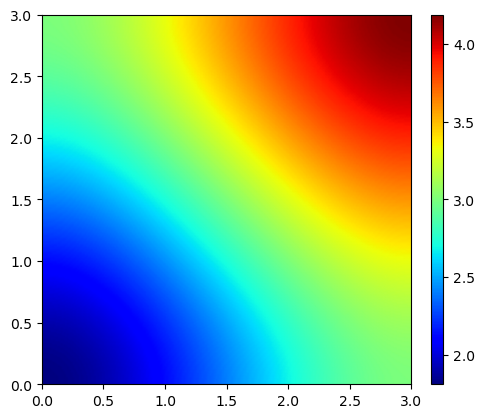

In [70]:
MP.plot(MP.Basis@u_sol)

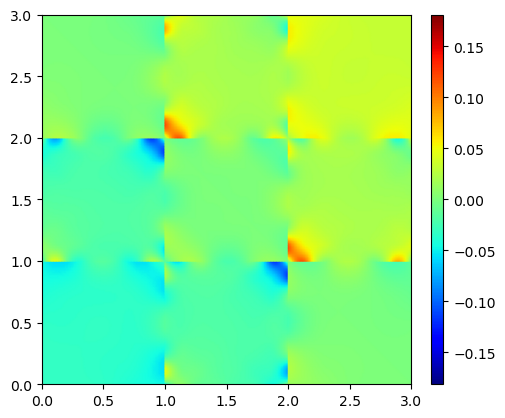

In [72]:
MP.plot(np.concatenate(u_loc0)-MP.Basis@u_sol)

In [229]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(1,2,3,5,8)
maxiter=len(degs)*(5,)
elim=0
fat=0
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=3
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = checkerboard(deg,2**(i+1),1)
        MP = assemble.Multipatch(M, automatch=True)
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="pseudo")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[i,k*j+2], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=100, P=MsD, output=1, tol=1e-8)
        res[i, k*j+1] = abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt', res, fmt=len(degs)*('%d', '%1.3f', '%d'), delimiter = " & ")   
    else:
        np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt', res, fmt=len(degs)*('%d', '%1.3f', '%d'), delimiter = " & ")   

deg = 1
setting up constraints took 0.01809978485107422 seconds.
Basis setup took 0.008177042007446289 seconds
Computing pseudoinverse took 0.0006439685821533203 seconds.
pcg with preconditioned condition number 1.380345355102085 stopped after 2 iterations with relres 5.2168300680783704e-17
#####################################################
setting up constraints took 0.020482540130615234 seconds.
Basis setup took 0.008625268936157227 seconds
Computing pseudoinverse took 0.0012814998626708984 seconds.
pcg with preconditioned condition number 1.5223204013428162 stopped after 5 iterations with relres 1.639575339453898e-10
#####################################################
setting up constraints took 0.024935245513916016 seconds.
Basis setup took 0.009042024612426758 seconds
Computing pseudoinverse took 0.006601572036743164 seconds.
pcg with preconditioned condition number 1.7268370813708804 stopped after 5 iterations with relres 4.040806726270456e-09
###############################

In [9]:
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}
degs=(1,2,3,5,8)
maxiter=len(degs)*(5,)
elim=1
fat=1
export=1

# num_dofs = np.empty((len(maxiter),len(deg)),dtype=int)
# num_primal = np.empty((len(maxiter),len(deg)),dtype=int)
# min_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# max_eig = np.empty((len(maxiter),len(deg)),dtype=float)
# it = np.empty((len(maxiter),len(deg)),dtype=int)

k=3
res = np.zeros((max(maxiter),len(degs)*k), dtype=float)

for j, deg in enumerate(degs):
    print("======================================================")
    print("deg = "+str(deg))
    for i in range(maxiter[j]):
        M = Lshape(deg,2**(i+1),5)
        MP = assemble.Multipatch(M, automatch=True)
        #res[i,k*j] = MP.N_ofs[-1]
        MP.set_dirichlet_boundary({0:g})
        #MP.mesh.draw(patch_idx=1,nodes=1,knots=1)
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(problem='(inner(grad(u),grad(v)))* dx',f=lambda x,y: 1.)
        I.construct_primal_constraints(redundant=False, fat=fat)
        I.construct_primal_basis()
        res[i,k*j] = I.Psi.shape[1]
        I.remove_dir_from_jumps()
        F,b= I.compute_F()
        #F_mat = F@np.eye(len(b))
        MsD = I.MsD(method="pseudo")
        #MsD_mat = MsD@np.eye(len(b))
        ### Solve the system with PCG
        lam, res[i,k*j+2], min_eig, max_eig, r = solvers.pcg(F, b, x0=np.random.rand(len(b)), maxiter=200, P=1, output=1, rtol=1e-6, atol=1e-12)
        print(min_eig, max_eig)
        res[i,k*j+1]=abs(max_eig/min_eig)
        #print(min_eig, max_eig)
        #w = I.construct_solution(lam)
        print("#####################################################")
if export:
    if elim:
        if fat:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim_fat.txt', res, fmt=len(degs)*('%d', '%1.3f', '%d'), delimiter = " & ")   
        else:
            np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt', res, fmt=len(degs)*('%d', '%1.3f', '%d'), delimiter = " & ") 
    else:
        np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt', res, fmt=len(degs)*('%d', '%1.3f', '%d'), delimiter = " & ")   

deg = 1
setting up constraints took 0.05449724197387695 seconds.
Basis setup took 0.009087085723876953 seconds
Computing pseudoinverse took 0.0005624294281005859 seconds.
Convergence condition: True
pcg with preconditioned condition number κ ~ 1.8758528664364222 stopped after 9 iterations with relres 4.981998755140175e-07
1.1990230809558176 2.2491908833344008
#####################################################
setting up constraints took 0.040607452392578125 seconds.
Basis setup took 0.008694887161254883 seconds
Computing pseudoinverse took 0.0010533332824707031 seconds.
Convergence condition: True
pcg with preconditioned condition number κ ~ 5.370591503186852 stopped after 19 iterations with relres 5.86549135713309e-07
1.1604236588971175 6.232161442569858
#####################################################
setting up constraints took 0.04196572303771973 seconds.
Basis setup took 0.009270906448364258 seconds
Computing pseudoinverse took 0.0029544830322265625 seconds.
Convergence co

In [71]:
Fmat = F.dot(np.eye(F.shape[0]))

In [73]:
algebra.condest(MsD@Fmat)

5.271205380497244

#####################################
setting up constraints took 0.018363237380981445 seconds.
Basis setup took 0.009409666061401367 seconds
4
10
pcg with preconditioned condition number 1.1104232399228329 stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00043201446533203125 seconds for 9 patches.
setting up constraints took 0.020048141479492188 seconds.
Basis setup took 0.009725570678710938 seconds
7
26
pcg with preconditioned condition number 1.242827242377967 stopped after 6 iterations with relres 9.877262513024327e-15
Refinement took 0.000331878662109375 seconds for 9 patches.
setting up constraints took 0.023079395294189453 seconds.
Basis setup took 0.01008152961730957 seconds
8
23
pcg with preconditioned condition number 1.3131180431114824 stopped after 6 iterations with relres 7.19027091678448e-11
Refinement took 0.0003571510314941406 seconds for 9 patches.
setting up constraints took 0.029850244522094727 seconds.
Basis setup took 0.01311326026916

/home/wolfman/anaconda3/lib/python3.9/site-packages/pyiga-0.1.0-py3.9-linux-x86_64.egg/pyiga/topology.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=kwargs.get('figsize'))


21
25
pcg with preconditioned condition number 1.769266987585349 stopped after 11 iterations with relres 2.2424118613517237e-11
Refinement took 0.0003402233123779297 seconds for 9 patches.
setting up constraints took 0.03714632987976074 seconds.
Basis setup took 0.018062114715576172 seconds
24
24
pcg with preconditioned condition number 1.7675684065257513 stopped after 11 iterations with relres 8.781202012645705e-11
Refinement took 0.00039577484130859375 seconds for 9 patches.
setting up constraints took 0.06232929229736328 seconds.
Basis setup took 0.034009695053100586 seconds
25
24
pcg with preconditioned condition number 1.7590407403296329 stopped after 12 iterations with relres 2.639155553047284e-11
Refinement took 0.00043511390686035156 seconds for 9 patches.
setting up constraints took 0.11404061317443848 seconds.
Basis setup took 0.09270548820495605 seconds


KeyboardInterrupt: 

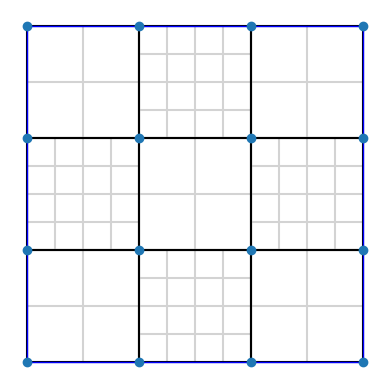

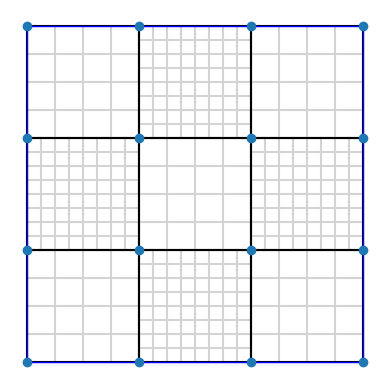

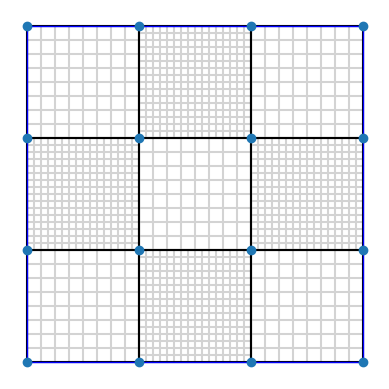

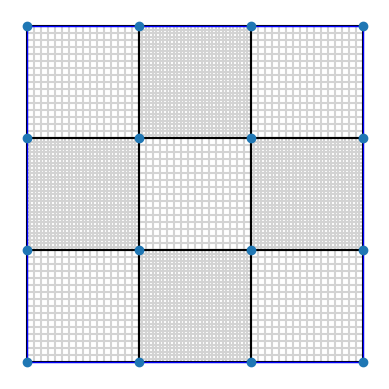

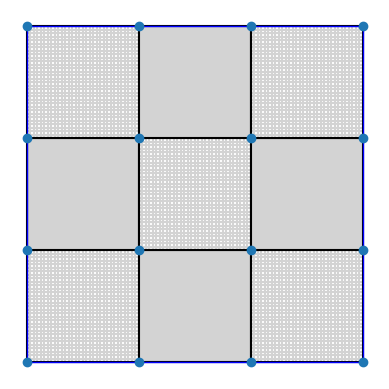

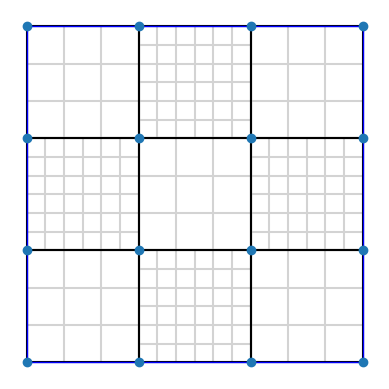

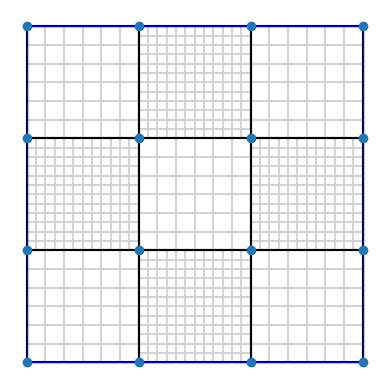

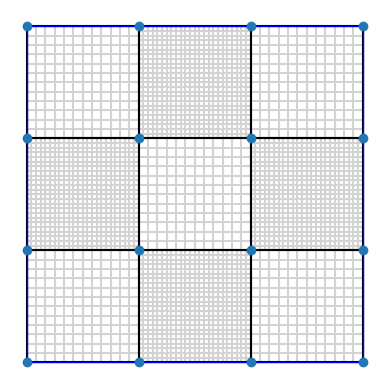

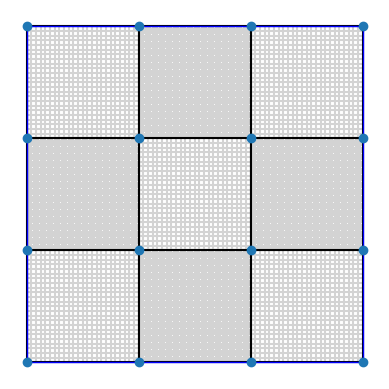

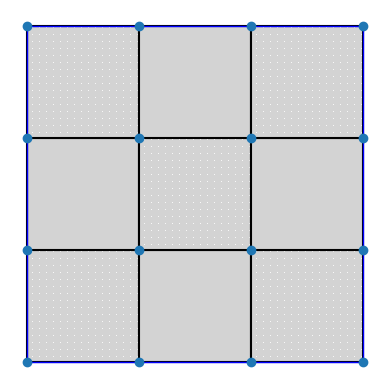

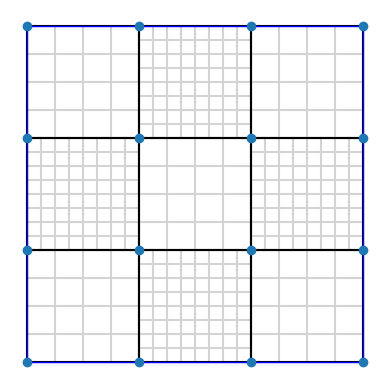

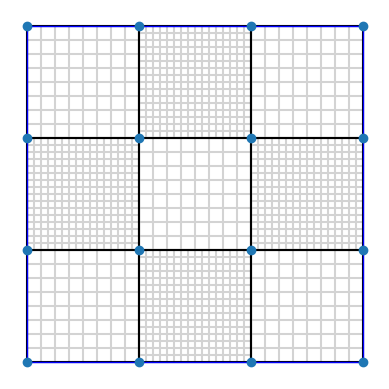

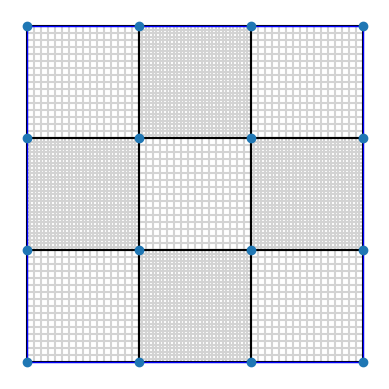

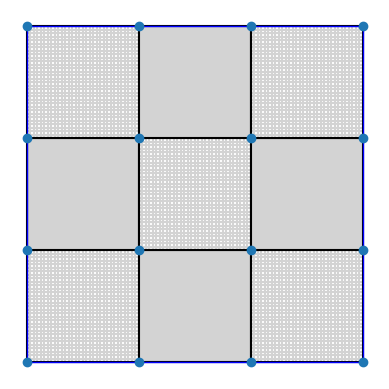

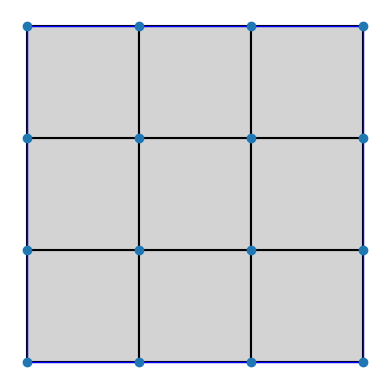

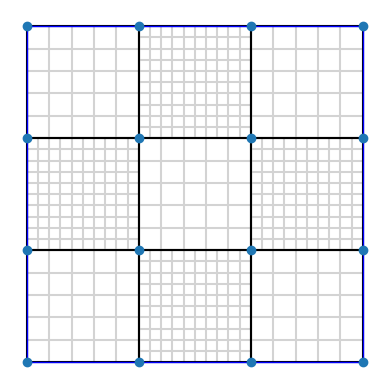

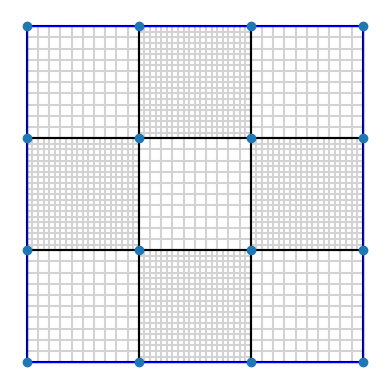

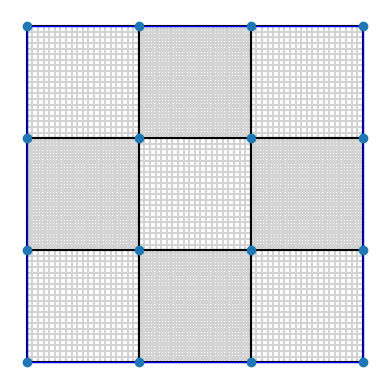

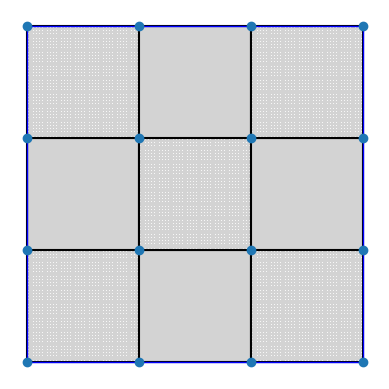

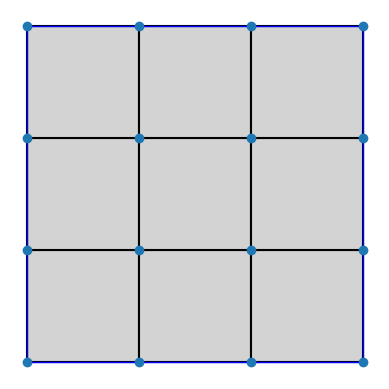

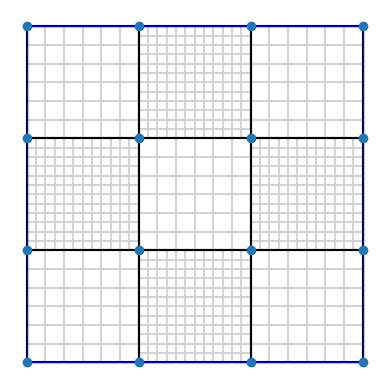

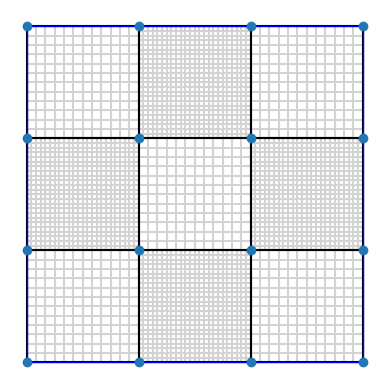

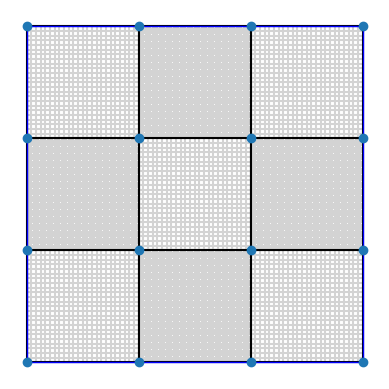

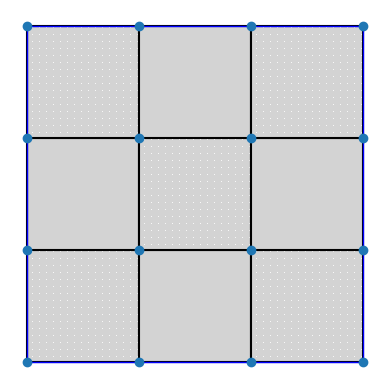

In [16]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=True)
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.017437458038330078 seconds.
Basis setup took 0.009253501892089844 seconds
pcg stopped after 2 iterations with relres 5.4951067048262263e-17
Refinement took 0.00016951560974121094 seconds for 4 patches.
setting up constraints took 0.01792740821838379 seconds.
Basis setup took 0.00933218002319336 seconds
pcg stopped after 4 iterations with relres 4.273988115438311e-17
Refinement took 0.0001652240753173828 seconds for 4 patches.
setting up constraints took 0.019681930541992188 seconds.
Basis setup took 0.009746074676513672 seconds
pcg stopped after 4 iterations with relres 9.358588499822341e-15
Refinement took 0.00015854835510253906 seconds for 4 patches.
setting up constraints took 0.021558284759521484 seconds.
Basis setup took 0.011844396591186523 seconds
pcg stopped after 4 iterations with relres 4.58228236822898e-13
Refinement took 0.00017547607421875 seconds for 4 patches.
setting up constraints took 0.02753949165344

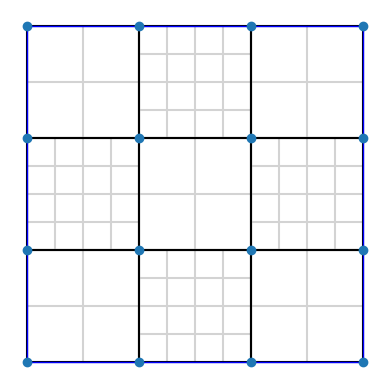

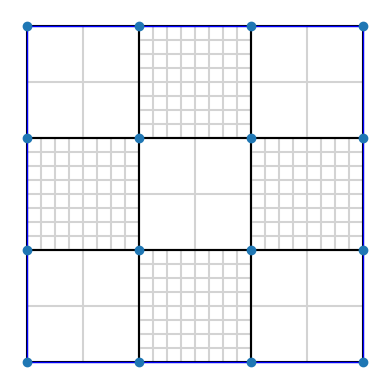

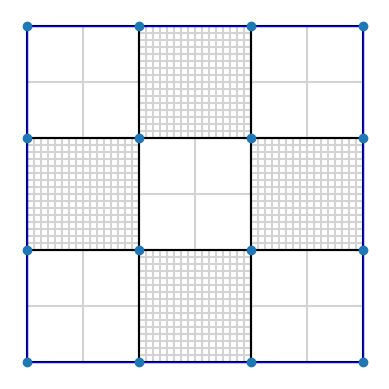

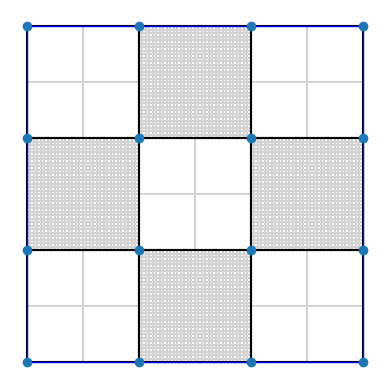

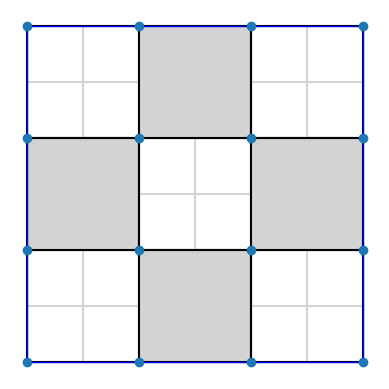

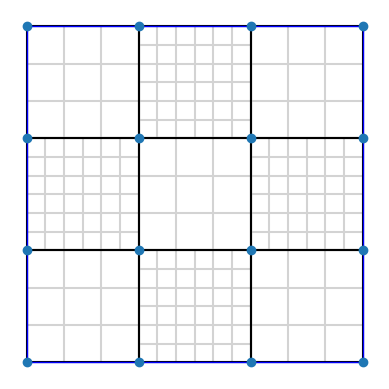

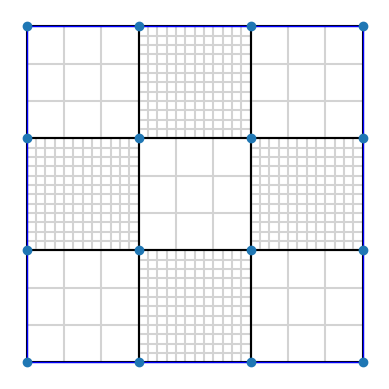

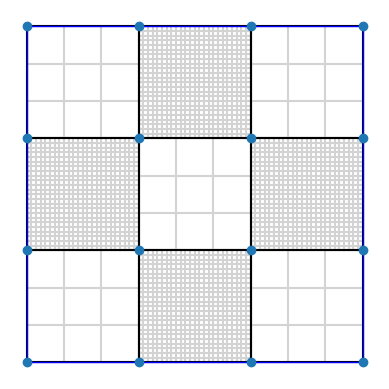

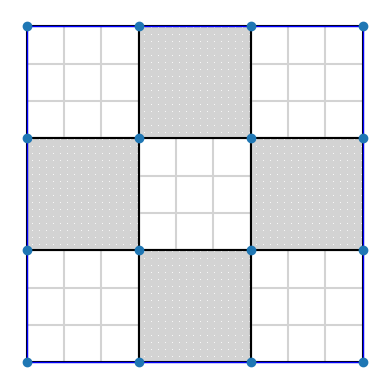

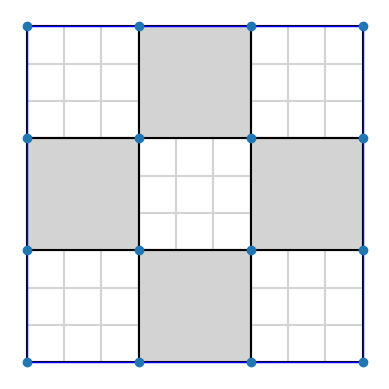

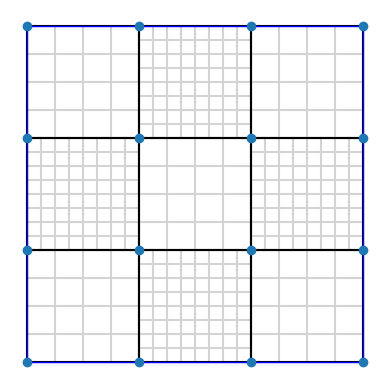

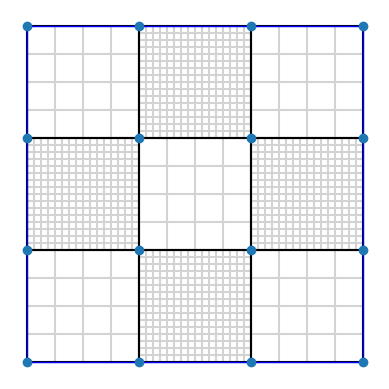

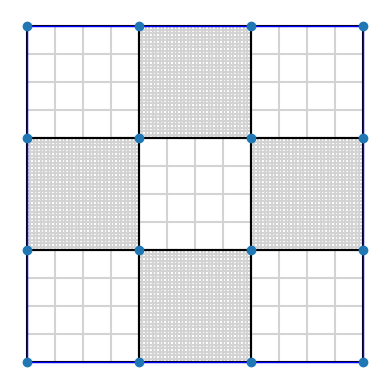

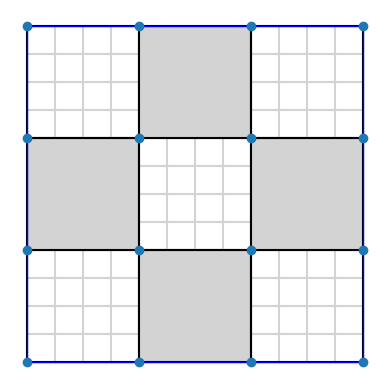

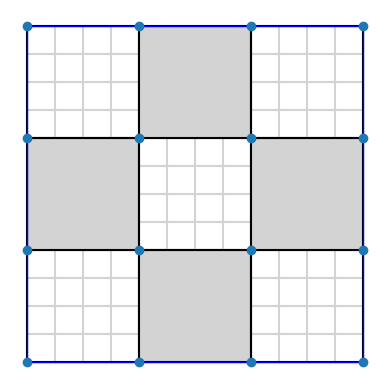

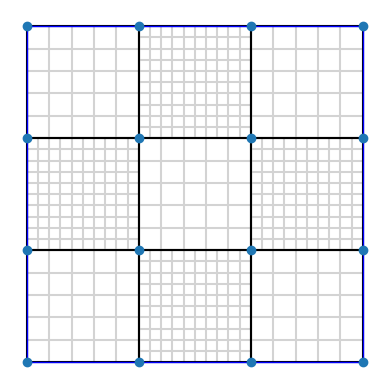

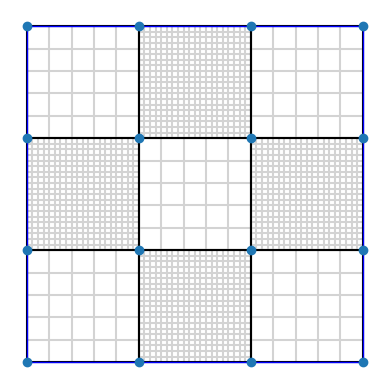

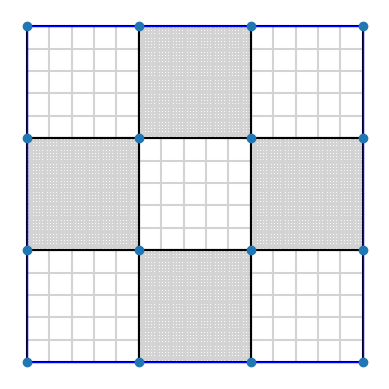

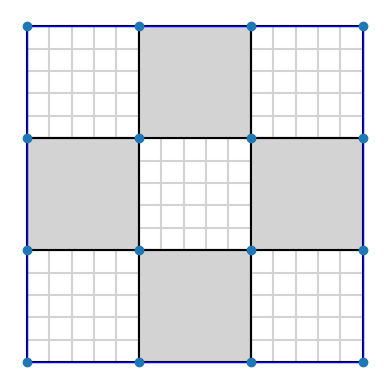

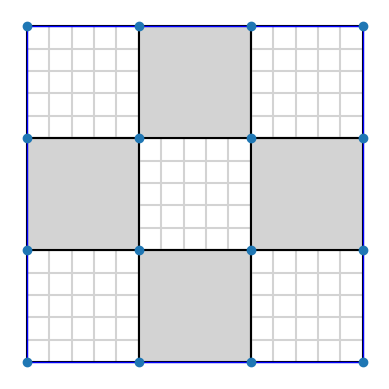

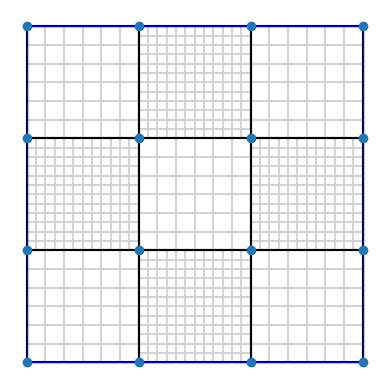

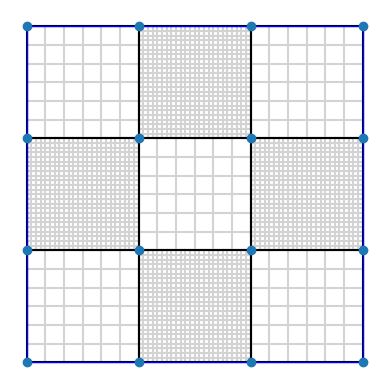

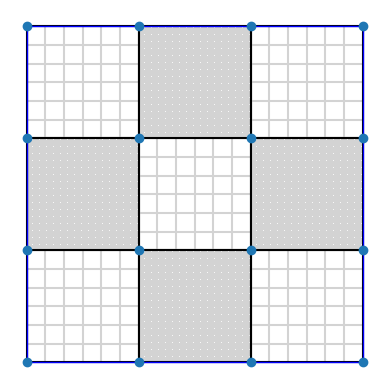

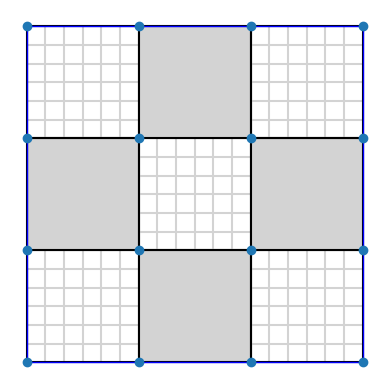

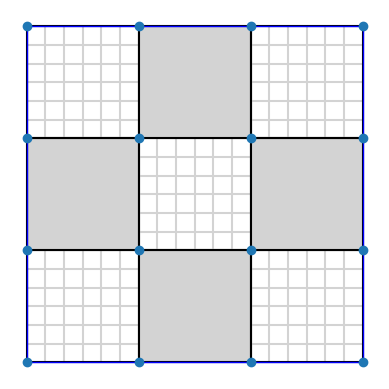

In [49]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((5,5))
it = np.zeros((5,5))
elim=False

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(5,))):
    print('#####################################')
    M = checkerboard(deg,deg+1,1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD()
        Fmat  = F.dot(np.eye(F.shape[0]))
        kappa[i,p]=algebra.condest(MsD@Fmat)
        lam, it[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        #MP.mesh.draw(patch_idx = 0, knots=1, bcolor={0:'blue'}, nodes=1, axis='off')
        axis('scaled');
        ###MP.h_refine(-1)
        MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_elim_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/checkerboard_dis.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

In [40]:
it

array([[1., 4., 4., 0., 0., 0.],
       [4., 6., 6., 0., 0., 0.],
       [5., 6., 7., 0., 0., 0.],
       [6., 7., 9., 0., 0., 0.],
       [7., 9., 9., 0., 0., 0.]])

In [ ]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

kappa = np.zeros((6,5))
it = np.zeros((6,5))
elim=True

for p, (deg, maxiter) in enumerate(zip((1,2,3,4,5),5*(6,))):
    print('#####################################')
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    MP.set_dirichlet_boundary({0:g})
    for i in range(maxiter):
        print('=====================================')
        I = IetiDP(MP, dir_data = {0:g}, elim=elim)
        I.assemble(f=lambda x,y: 1.)
        I.construct_primal_constraints()
        I.construct_primal_basis()
        F,b= I.compute_F()
        MsD = I.MsD(pseudo=False)
        lam, it[i,p], kappa[i,p], r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-10)
        axis('scaled');
        MP.h_refine(-1)
        ###MP.h_refine({i : -1 for i in range(9) if i%2==1})
        MP.set_dirichlet_boundary({0:g})
        
result = np.zeros((5,10))
result[:,np.array([0,2,4,6,8])]=kappa
result[:,np.array([1,3,5,7,9])]=it

if elim:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape_elim.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")
else:
    np.savetxt('/home/wolfman/Documents/IETI/Lshape.txt',result, fmt=5*('%1.1f','%d'), delimiter = " & ")              

#####################################
setting up constraints took 0.08600449562072754 seconds.
Basis setup took 0.014266014099121094 seconds
pcg with preconditioned condition number 1.0972303562262358 stopped after 5 iterations with relres 2.1033830757006824e-11
Refinement took 0.0010564327239990234 seconds for 31 patches.
setting up constraints took 0.07834243774414062 seconds.
Basis setup took 0.013842582702636719 seconds
pcg with preconditioned condition number 1.671463683434546 stopped after 10 iterations with relres 4.9938397508517634e-11
Refinement took 0.0012252330780029297 seconds for 31 patches.
setting up constraints took 0.08354926109313965 seconds.
Basis setup took 0.015346527099609375 seconds
pcg with preconditioned condition number 1.2749844484684212 stopped after 13 iterations with relres 3.0492980297062935e-11
Refinement took 0.00106048583984375 seconds for 31 patches.
setting up constraints took 0.1029202938079834 seconds.
Basis setup took 0.020825624465942383 seconds
